# <center><b><font color='blue'>Bitcoin Price Prediction</font></b></center>

TABLA DE CONTENIDO

...

<a name="1"></a>
## 1. Objetivos

Aprender acerca de las series temporales.

<a name="2"></a>
## 2. Librerías necesarias

In [36]:
# que no se impriman info y warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

In [37]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from tensorflow.keras import layers,callbacks,models,Sequential,losses
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from keras import backend as K
import os,random
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers.experimental import preprocessing
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import csv
from datetime import datetime

<a name="3"></a>
## 3. Helper Functions

In [38]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
    """
    Plots timesteps (a series of points in time) against values (a series of values across timesteps).

    Parameters
    ----------
    timesteps : array of timestep values
    values : array of values across time
    format : style of plot, default "."
    start : where to start the plot (setting a value will index from start of timesteps & values)
    end : where to end the plot (similar to start but for the end)
    label : label to show on plot about values, default None 
    """
    # Plot the series
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("BTC Price")
    if label:
        plt.legend(fontsize=14) # make label bigger
    plt.grid(True)


    
# se implementa MASE pues no existe en TF
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true-y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shift of 1)

  return mae / mae_naive_no_season
    
    
    
# make predictions
def make_preds(model, input_data):
    """
    Uses model to make predictions input_data.
    """    
    forecast = model.predict(input_data)
    return tf.squeeze(forecast) # return 1D array of predictions



# Evaluaci[on  de predicciones

# Create a function to take in model predictions and truth values and return evaluation metrics
# sirve para horizonte largo 1
def evaluate_preds(y_true, y_pred):
  # Make sure float32 datatype (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various evaluation metrics 
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}


# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_preds_general(y_true, y_pred):
  # Make sure float32 datatype (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various evaluation metrics 
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, we want to reduce metrics to a single value)
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}




# Make the train/test splits para nuestro dataset ventaneado
def make_train_test_splits(windows, labels, test_split=0.2):
    """
    Splits matching pairs of winodws and labels into train and test splits.
    
    Recine arreglos de numpy
    Devuelve arreglos de numpy
    
    """
    split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test: len(windows)=2780 aqu[i
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows, test_windows, train_labels, test_labels

# create windowed dataset
def create_windowed_dataset(dataset,window_size):
    """
    dataset: a dataset with a key "price"
    window size
    """
    # Make a copy of the Bitcoin historical data with block reward feature
    dataset_windowed = dataset.copy()
    # Add windowed columns
    for i in range(window_size): # shift values for each step in WINDOW_SIZE
        dataset_windowed[f"Price+{i+1}"] = dataset_windowed["Price"].shift(periods=i+1)
        
    
    # drop nan values
    dataset_windowed.dropna(inplace=True)
    
    # convert to float32
    dataset_windowed["Price"] = dataset_windowed["Price"].astype(np.float32)

    # return
    return dataset_windowed

<a name="4"></a>
## 4. Carga y pre-procesamiento de datos

Descargamos los datos de https://www.coindesk.com/price/bitcoin/

In [4]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv 

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [39]:
# importamos los datos con pandas

df = pd.read_csv("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates=["Date"],
                 index_col=["Date"]) # prase the date column and tell pandas column 1 is a datetime 

df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [54]:
df.shape

(2787, 5)

In [40]:
# me quedo sólo con lo que preciso y hago un rename
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


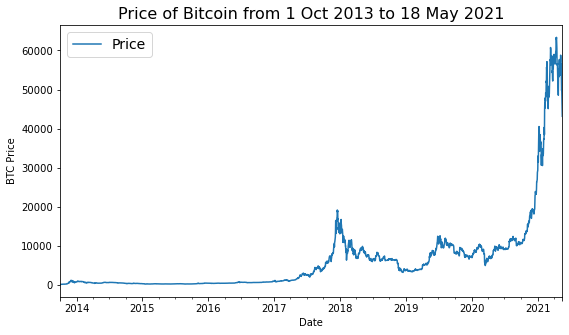

In [41]:
bitcoin_prices.plot(figsize=(9, 5))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

### Train test split

NO puedo usar train_test_split de sklearn así nomás, pues hace una división aleatoria y esto es una serie temporal; el orden importa!!!

Por ello, en lugar de usar train/test/split de ScikitLearn, usaremos slicing.

In [42]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [43]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test - you can change these values as needed, e.g. 90/10, 95/5

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything beyond the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

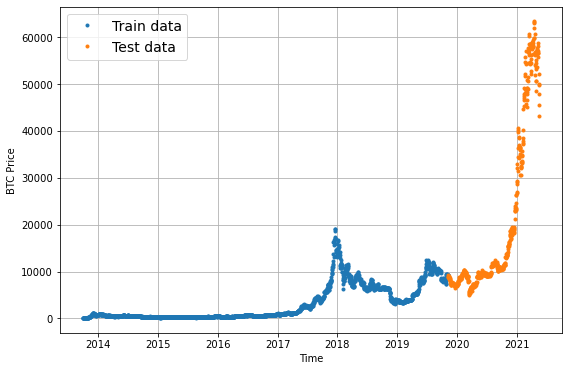

In [44]:
# Test out plotting function
plt.figure(figsize=(9, 6))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

<a name="6"></a>
## 5. Modelos

Terms to be familiar with:
* **Horizon** = number of timesteps into the future we're going to predict
* **Window size** = number of timesteps we're going to use to predict **horizon**

Modelling experiments we're running:
* 0	Naïve model (baseline)	
* 1	Dense model, horizon = 1, window = 7
* 2	Same as 1, 	horizon = 1, window = 30
* 3	Same as 1, 	horizon = 7, window =	30
* 4	Conv1D
* 5	LSTM

### 5.1. Naive Forecast

The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$

In English:

> The prediction at timestep t (y-hat) is equal to the value at timestep t-1 (previous timestep) - this is for a horizon of 1.

In [45]:
# Create a naive forecast 
naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

----------------------- GRAFICAS!!!!!!!!!!

### Model 1: Dense model (window = 7, horizon = 1)

Our first deep model is going to be a simple dense model:
* A single dense layer with 128 hidden units and ReLU
* An output layer with linear activation (no activation)
* Adam optimizaiton and MAE loss function
* Batch size of 128 (previously we've used 32) 
* 100 epochs 

Why these values?

I picked them out of experimentation.

* **Hyperparameters** = values a machine learning practitioner (you!) can adjust themselves
* **Parameters** = values a model learns on its own

In [63]:
# Setup dataset hyperparameters
HORIZON_M1 = 1
WINDOW_SIZE_M1 = 7

In [64]:
bitcoin_windowed_m1 = create_windowed_dataset(bitcoin_prices,WINDOW_SIZE_M1)

In [65]:
# Create X (windows) and y (horizons) features
X = bitcoin_windowed_m4.drop("Price", axis=1)
y = bitcoin_windowed_m4["Price"]

In [66]:
X_train, X_test, y_train, y_test = make_train_test_splits(X.values, y.values)
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [67]:
# 1. Construct model
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear")               
], name="model_1_dense") # name our model so we can save it

# 2. Compile
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae", "mse"])

# 3. Fit the model
model_1.fit(x=X_train,
            y=y_train,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(X_test, y_test))
            #callbacks=[create_model_checkpoint(model_name=model_1.name)])

In [68]:
# Evaluate model on test data
model_1.evaluate(X_test, y_test)

18/18 [==============================] - 0s 5ms/step - loss: 581.4818 - mae: 581.4818 - mse: 1182630.5000


[581.4818115234375, 581.4818115234375, 1182630.5]

In [69]:
model_1.predict

<bound method Model.predict of <keras.engine.sequential.Sequential object at 0x000001FC1B994CD0>>

In [70]:
# Make predictions using model_1 on the test dataset and view results
model_1_preds = make_preds(model_1, X_test) 
len(model_1_preds), model_1_preds[:10]

18/18 [==============================] - 0s 4ms/step


(556,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8790.473 , 8728.201 , 8976.211 , 8696.999 , 8694.8545, 8689.759 ,
        8615.991 , 8461.55  , 8413.3955, 8469.261 ], dtype=float32)>)

In [71]:
# Evaluate preds
model_1_results = evaluate_preds_general(y_true=tf.squeeze(y_test),
                                 y_pred=model_1_preds) # ídem con evaluate_preds
model_1_results

{'mae': 581.48157,
 'mse': 1182630.5,
 'rmse': 1087.4882,
 'mape': 2.5961907,
 'mase': 1.021502}

In [ ]:
### Model 1: Dense model (window = 7, horizon = 1)

### Model 4 : Conv1D

1. Crear ventanas

2. Train/test split

In [6]:
HORIZON = 1 # predict next day of Bitcoin prices
WINDOW_SIZE = 7 # use previous week worth data

In [15]:
bitcoin_windowed_m4 = create_windowed_dataset(bitcoin_prices,WINDOW_SIZE)

In [16]:
bitcoin_windowed_m4.head(10)

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,123.032997,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.049004,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500
2013-10-10,125.961159,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483
2013-10-11,125.279663,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466
2013-10-12,125.927498,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866
2013-10-13,126.383331,125.92750,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533
2013-10-14,135.241989,126.38333,125.92750,125.27966,125.96116,124.04900,123.03300,121.79500
2013-10-15,133.203323,135.24199,126.38333,125.92750,125.27966,125.96116,124.04900,123.03300
2013-10-16,142.763336,133.20333,135.24199,126.38333,125.92750,125.27966,125.96116,124.04900


In [18]:
# Create X (windows) and y (horizons) features
X = bitcoin_windowed_m4.drop("Price", axis=1)
y = bitcoin_windowed_m4["Price"]

In [19]:
type(X)

pandas.core.frame.DataFrame

In [22]:
# train/test split


train_windows, test_windows, train_labels, test_labels = make_train_test_splits(X.values, y.values)
len(train_windows), len(train_labels), len(test_windows), len(test_labels)


(2224, 2224, 556, 556)

In [23]:
type(train_windows)

numpy.ndarray

To use the Conv1D layer, we need an input shape of: `(batch_size, timesteps, input_dim)`...

However our data isn't in that shape yet...

En el contexto de un problema de series temporales con un horizonte (horizon) de 1 y un tamaño de ventana (window_size) de 7, la forma del tensor de entrada (input_shape) sería crucial para determinar el tamaño de input_dim. La forma general del tensor sería (batch_size, window_size, input_dim).

Dado que window_size es 7, el modelo consideraría secuencias de 7 pasos temporales como entrada en cada lote. Sin embargo, el horizonte de predicción (horizon) es 1, lo que significa que el modelo está diseñado para predecir el siguiente paso temporal en cada secuencia.

Por lo tanto, el tamaño de input_dim debe ser el número de características o variables en cada paso temporal. Si tus secuencias tienen una única característica en cada paso de tiempo (por ejemplo, univariadas), entonces input_dim sería 1. Si tienes múltiples características en cada paso de tiempo (por ejemplo, series temporales multivariadas), entonces input_dim sería el número total de características.

Entonces, en resumen, para un problema de series temporales con un horizonte de 1 y una ventana de 7, y si tus datos tienen una sola característica en cada paso de tiempo, input_dim debería ser 1. Si tienes múltiples características en cada paso de tiempo, input_dim sería el número total de características.

In [24]:
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension for `input_dim`

In [27]:



x = tf.constant(train_windows[0]) #.values[0]) # convierto df a numpy<   train_windows.values[0]

# Test out our lambda layer
print(f"Original shape: {x.shape}") # (WINDIW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}") # output = ...?
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")


Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[121.795  ]
 [120.65533]
 [121.33866]
 [118.67466]
 [108.58483]
 [125.455  ]
 [123.65499]]


In [121]:
def build_model_4(x,horizon):
    model = tf.keras.Sequential([
        layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
        tf.keras.layers.Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="relu"),
        tf.keras.layers.Dense(horizon)
    ],name="model_4_conv1D")
    return model
    
    
model_4 = build_model_4(x,1)

In [122]:
# Compile model
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_4.fit(train_windows.values,
            train_labels.values,
            batch_size=128, 
            epochs=100,
            verbose=1,
            validation_data=(test_windows.values, test_labels.values))
            #callbacks=[create_model_checkpoint(model_name=model_4.name)])

Epoch 1/100
18/18 [==============================] - 1s 14ms/step - loss: 3065.1082 - val_loss: 13563.0303
Epoch 2/100
18/18 [==============================] - 0s 5ms/step - loss: 2974.7793 - val_loss: 15546.4258
Epoch 3/100
18/18 [==============================] - 0s 4ms/step - loss: 2954.7710 - val_loss: 17140.9844
Epoch 4/100
18/18 [==============================] - 0s 3ms/step - loss: 2954.6580 - val_loss: 16327.9170
Epoch 5/100
18/18 [==============================] - 0s 3ms/step - loss: 2951.8987 - val_loss: 16716.4160
Epoch 6/100
18/18 [==============================] - 0s 4ms/step - loss: 2954.7644 - val_loss: 16569.3340
Epoch 7/100
18/18 [==============================] - 0s 4ms/step - loss: 2953.8386 - val_loss: 16800.7051
Epoch 8/100
18/18 [==============================] - 0s 4ms/step - loss: 2953.5835 - val_loss: 16290.8252
Epoch 9/100
18/18 [==============================] - 0s 4ms/step - loss: 2952.2244 - val_loss: 16610.1543
Epoch 10/100
18/18 [=========================

In [72]:
train_windows[0]

array([121.795  , 120.65533, 121.33866, 118.67466, 108.58483, 125.455  ,
       123.65499], dtype=float32)

In [95]:
train_windows.shape

(2224, 7)

In [94]:
test_windows.shape

(556, 7)

In [105]:


type(train_windows)


pandas.core.frame.DataFrame

### Model 5: RNN (LSTM)

Let's build an RNN model for our time series data.

We'll use the same data we created previously.

In [29]:
def build_model_5(window_size):
    # Let's build an LSTM model with the Functional API
    inputs = layers.Input(shape=(window_size))
    x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
    # x = layers.LSTM(128, return_sequences=True)(x)
    x = layers.LSTM(128, activation="relu")(x)
    # x = layers.Dense(32, activation="relu")(x)
    output = layers.Dense(HORIZON)(x)
    model = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_LSTM")
    return model


model_5 = build_model_5(WINDOW_SIZE)
    
    
# Compile
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels
                            ))
            #callbacks=[create_model_checkpoint(model_name=model_5.name)])

Epoch 1/100
18/18 [==============================] - 5s 62ms/step - loss: 2508.2883 - val_loss: 8053.6123
Epoch 2/100
18/18 [==============================] - 0s 21ms/step - loss: 520.1105 - val_loss: 1752.0551
Epoch 3/100
18/18 [==============================] - 0s 18ms/step - loss: 246.1874 - val_loss: 1342.0322
Epoch 4/100
18/18 [==============================] - 0s 17ms/step - loss: 188.9380 - val_loss: 965.4466
Epoch 5/100
18/18 [==============================] - 0s 16ms/step - loss: 169.9010 - val_loss: 1040.0973
Epoch 6/100
18/18 [==============================] - 0s 16ms/step - loss: 179.7647 - val_loss: 908.2889
Epoch 7/100
18/18 [==============================] - 0s 15ms/step - loss: 185.7018 - val_loss: 1093.7377
Epoch 8/100
18/18 [==============================] - 0s 14ms/step - loss: 189.3978 - val_loss: 1060.7153
Epoch 9/100
18/18 [==============================] - 0s 16ms/step - loss: 187.1630 - val_loss: 1055.3829
Epoch 10/100
18/18 [==============================] - 0s

Epoch 79/100
18/18 [==============================] - 0s 15ms/step - loss: 120.6368 - val_loss: 626.5648
Epoch 80/100
18/18 [==============================] - 0s 15ms/step - loss: 118.8994 - val_loss: 614.0759
Epoch 81/100
18/18 [==============================] - 0s 15ms/step - loss: 115.8028 - val_loss: 623.5986
Epoch 82/100
18/18 [==============================] - 0s 17ms/step - loss: 113.5314 - val_loss: 606.4968
Epoch 83/100
18/18 [==============================] - 0s 16ms/step - loss: 115.7995 - val_loss: 614.7435
Epoch 84/100
18/18 [==============================] - 0s 16ms/step - loss: 113.3361 - val_loss: 605.8349
Epoch 85/100
18/18 [==============================] - 0s 15ms/step - loss: 113.1689 - val_loss: 621.9846
Epoch 86/100
18/18 [==============================] - 0s 16ms/step - loss: 113.6675 - val_loss: 656.4463
Epoch 87/100
18/18 [==============================] - 0s 15ms/step - loss: 113.6878 - val_loss: 605.4370
Epoch 88/100
18/18 [==============================] - 0

In [34]:
train_labels

array([ 123.033  ,  124.049  ,  125.96116, ..., 9335.752  , 9226.485  ,
       8794.358  ], dtype=float32)

ANEXO , explico windowed dataset

EVALUANDO SERIES TEMPORALES

Let's look into some evaluation metrics for time series forecasting. 

What are we doing?

We're predicting a number, so that means we have a form of a regression problem.

Because we're working on a regression problem, we'll need some regression-like metrics.

A few common regression metrics (which can also be used for time series forecasting):
* MAE - mean absolute error
* MSE - mean squared error
* RMSE - root mean square error
* MAPE/sMAPE - (symmetric) mean absolute percentage error
* MASE - mean absolute scaled error

For all of the above metrics, **lower is better**, for example, an MAE of 0 that is better than an MAE of 100.

The main thing we're evaluating here is: **how do our model's forecasts (y_pred) compare against the actual values (y_true or ground truth values)?**

> 📖 **Resource:** For a deeper dive on the various kinds of time series forecasting methods see [Forecasting: Principles and Practice chapter 5.8](https://otexts.com/fpp3/accuracy.html) 

#### <font color='#9400D3'> Format Data Part 2: Windowing our dataset </font>


--> Antes usamos train/dev/test, ahora usaremos ventanas

Creamos ventanas para convertir nuestros datos en un problema de aprendizaje supervisado


```
Windowing for one week
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]


```

Usaremos https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html para crear las venatas con Pandas.

In [ ]:
def create_windowed_dataset(dataset,window_size):
    """
    dataset: a dataset with a key "price"
    window size
    """
    # Make a copy of the Bitcoin historical data with block reward feature
    dataset_windowed = dataset.copy()
    # Add windowed columns
    for i in range(window_size): # shift values for each step in WINDOW_SIZE
        dataset_windowed[f"Price+{i+1}"] = dataset_windowed["Price"].shift(periods=i+1)
        
    
    # podr[ia devolverlo como arreglo de numpy (con df.values o to_numpy())
    
    return dataset_windowed


# drop nan values

# Create X (windows) and y (horizons) features
X = bitcoin_windowed_m4.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_windowed_m4.dropna()["Price"].astype(np.float32)


bitcoin_windowed_m4 = create_windowed_dataset(bitcoin_prices,WINDOW_SIZE)